# Proyecto Final: Resultados

_Jorge III Altamirano Astorga, Luz Aurora Hernández Martínez, Ita-Andehui Santiago Castillejos._

En este notebook crearemos gráficas comparativas sobre los modelos para visualizar el desempeño.

In [1]:
import re, os, sys, shelve, time, dill, io
from pickle import PicklingError
from dill import Pickler, Unpickler
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
from IPython.display import display, Markdown, Math, clear_output, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

base_url = ""
# File Loaders
try:
    base_url = "drive/MyDrive/Colab Notebooks/proyecto-final"
    uploaded = os.path.join(base_url, "data/sinaica-imputated.pickle.gz")
    if(not os.path.isfile(uploaded)):
        from google.colab import files
        uploaded = files.upload()
except:
  base_url = ""
  uploaded = "data/sinaica/sinaica-imputated.pickle.gz"

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    Taken from https://stackoverflow.com/a/39358722/7323086
    """
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', size=font_size*1.05)
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    plt.show()

#df.dropna(inplace=True)
clear_output()

def performance_plot(history, a=None, b=None, 
                    metrics=["accuracy", "val_accuracy"],
                    plot_validation=True,
                    title="Gráficas de Desempeño."):
  """
  Prints performance plot from a, to b on a history dict.
  
  Inputs:
  history: dict containing "loss" and "accuracy" keys
  a: epoch start
  b. last epoch
  metrics: plot these metrics (train and validation). Always 2.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  if a is None:
      a = 0
  if b is None:
      b = len(history['loss'])
  a = np.min((a,b))
  b = np.max((a,b))

  imgrows = (len(metrics) + 1) / 2
  imgrows = np.round(imgrows, 0)
  imgrows = int(imgrows)
  #print(imgrows)

  # Plot loss
  plt.figure(figsize=(14, 5
                      *imgrows))
  plt.suptitle(title)
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  for i, metric in enumerate(metrics): 
    #print(f"metric: {metric}, i: {i}")
    #print(f"mean metric: {np.mean(history[metric])}")
    plt.subplot(imgrows, 2, i+2)
    plt.title(metric)
    plt.plot(history[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(history["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xlim(a, b)
    #print(range(0, b-a))
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()

#render_mpl_table(df.head().applymap(shorten), col_width=5)

sinaica = pd.read_pickle(uploaded)
airdata = pd.read_pickle(os.path.join(base_url, "data/airdata/air-imputated.pickle.gz"))
#sinaica.head()

# Datos del Gobierno y del Sensor

En esta sección utilizaremos los datos de las estaciones de monitoreo de contaminantes de la Ciudad de México y los Datos del Sensor.



## Resultados

In [2]:
models = []
object_names = []
models_path = os.path.join(base_url, "models-sinaica")

for y in [x for x in os.listdir(models_path) if x.endswith("dill")]:
  model_path = os.path.join(models_path, y)
  with io.open(model_path, 'rb') as file:
      object_name = re.sub(r"\.", "_", y)
      object_name = re.sub(r"_dill", "", object_name)
      globals()[object_name] = dill.load(file)
      object_names.append(object_name)
#display(Markdown("Objetos cargados: \n\n>" + 
#         ", ".join(object_names)))

model_times = [o for o in object_names if o.endswith("_time")]
perf_table = pd.DataFrame({
  "Modelo": [re.sub("_time$", "", model_time) for model_time in model_times],
  "Tiempo": [globals()[model_time] for model_time in model_times]
})
df_n_params = pd.DataFrame(data={
    "Modelo": [x for x in model_n_params.keys()],
    "# Params": [x for x in model_n_params.values()]
})
perf_table = perf_table.merge(df_n_params, on="Modelo")
model_path = os.path.join(models_path, "model_n_params.dill")
model_n_params = dill.load(open(model_path, 'rb'))
model_histories = [o 
                   for o in object_names 
                   if o.endswith("_hist")
                  ]
model_metrics = [k 
                 for k in globals()[model_histories[0]].keys()
                 if re.search("^(val_|loss)", k) is None
                ]

for metric in model_metrics:
  perf_table["val_" + metric] = [np.mean(globals()[o]["val_" + metric]) for o in model_histories]
for metric in model_metrics:
  perf_table[metric] = [np.mean(globals()[o][metric]) for o in model_histories]
perf_table.rename({
  "mean_squared_logarithmic_error": "msle",
  "val_mean_squared_logarithmic_error": "val_msle"
}, axis=1, inplace=True)
perf_table.drop(["loss", "val_loss"], axis=1, inplace=True, errors='ignore')
perf_table.sort_values("val_mse", inplace=True)
perf_table["Tiempo"] = (perf_table["Tiempo"] // 60).astype('int').astype("str") + "m" + \
(perf_table["Tiempo"] % 60).round(3).apply(lambda x: f"{x:2.2f}") + "s"
perf_table.reset_index(inplace=True, drop=True)
#perf_table.round(4)
excluded_columns = ["iaqAccuracy", "datetime", "datetime-1", "delta", 
                    "imputated", "year"]
train, test = train_test_split(sinaica[[x 
                                        for x in sinaica.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.8, random_state=175904, shuffle=False)
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
perf_data_iaq = scaler_iaq.inverse_transform(perf_table.select_dtypes("float64"))
#scaler_gr = MinMaxScaler().fit(train[["gasResistance"]])
#perf_data_gr = scaler_gr.inverse_transform(perf_table.select_dtypes("float64"))
perf_data_iaq = pd.DataFrame(perf_data_iaq, 
                             columns=perf_table.select_dtypes("float64").columns)
#perf_data_gr  = pd.DataFrame(perf_data_gr, 
#                             columns=perf_table.select_dtypes("float64").columns)
perf_data_iaq.insert(0, "Tiempo", perf_table["Tiempo"], )
#perf_data_gr.insert(0,  "Tiempo", perf_table["Tiempo"], )
perf_data_iaq.insert(0, "Modelo", perf_table["Modelo"], )
#perf_data_gr.insert(0,  "Modelo", perf_table["Modelo"], )
perf_data_iaq["# Params"] = perf_table["# Params"]
#perf_data_gr["# Params"]  = perf_table["# Params"]
perf_data = perf_table.copy()
perf_data.sort_values("val_mse", inplace=True)
perf_data.reset_index(inplace=True, drop=True)
model_number_rows = [int(re.sub("[^0-9]", "", x)) for x in perf_table["Modelo"]]
#is_gr_row = [(x % 2) == 0 for x in model_number_rows]
is_iaq_row = [(x % 2) == 1 for x in model_number_rows]
#perf_data.iloc[is_gr_row] = perf_data_gr
perf_data.iloc[is_iaq_row] = perf_data_iaq
cols = ["Modelo", "Tiempo", "# Params", "val_mae", "mae"]
perf_data.round(2)[cols]

,Modelo,Tiempo,# Params,val_mae,mae
0,model_conv01,2m53.16s,"116,225",80.26,61.04
1,model_conv03,6m56.74s,"509,953",83.18,52.96
2,model_baseline01,1m9.73s,16,81.68,55.41
3,model_rnn03,11m58.17s,"288,833",83.38,53.35
4,model_best01b,9m34.02s,"169,795",90.47,61.12
5,model_dnn03,3m14.81s,"26,689",95.57,48.06
6,model_dnn01,1m33.90s,"8,705",102.19,46.67
7,model_lstm03,6m13.69s,"185,345",123.23,61.76
8,model_lstm01,2m24.19s,"54,273",145.06,116.66
9,model_best01a,15m37.22s,"575,745",190.37,196.80


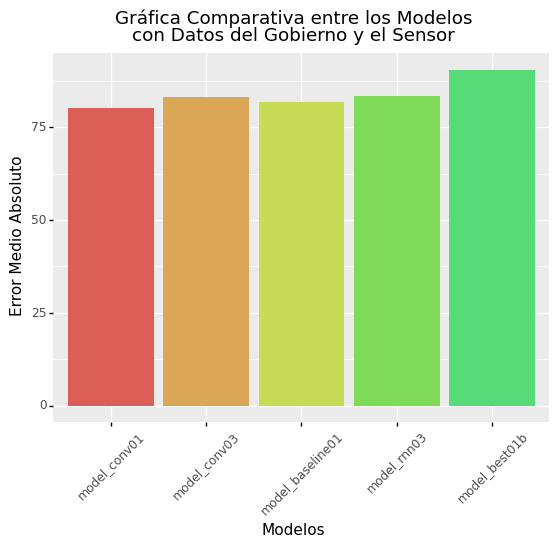

<ggplot: (8756075465369)>

In [3]:
Modelos_list = perf_data["Modelo"].tolist()
Modelos = pd.Categorical(perf_data["Modelo"], 
                         categories=Modelos_list)
perf_data["Modelo2"] = Modelos
(
  ggplot(perf_data.head(5), aes(x="Modelo2", y="val_mae", fill="Modelo2")) +
  geom_bar(stat="identity") +
  #geom_bar(aes(y="mae"), stat="identity") +
  labs(y="Error Medio Absoluto", x="Modelos", 
       title="Gráfica Comparativa entre los Modelos\ncon Datos del Gobierno y el Sensor"
      ) +
  theme(legend_position="none", axis_text_x=element_text(rotation=45))
)

# Datos del Sensor

En esta sección utilizaremos los datos del Sensor.



## Resultados

In [4]:
models = []
object_names = []
models_path = os.path.join(base_url, "models")

for y in [x for x in os.listdir(models_path) if x.endswith("dill")]:
  model_path = os.path.join(models_path, y)
  with io.open(model_path, 'rb') as file:
      object_name = re.sub(r"\.", "_", y)
      object_name = re.sub(r"_dill", "", object_name)
      globals()[object_name] = dill.load(file)
      object_names.append(object_name)
#display(Markdown("Objetos cargados: \n\n>" + 
#         ", ".join(object_names)))

model_times = [o for o in object_names if o.endswith("_time")]
perf_table = pd.DataFrame({
  "Modelo": [re.sub("_time$", "", model_time) for model_time in model_times],
  "Tiempo": [globals()[model_time] for model_time in model_times]
})
model_path = os.path.join(models_path, "model_n_params.dill")
model_n_params = dill.load(open(model_path, 'rb'))
#pd.DataFrame(model_n_params, columns=["# Parametros"])
df_n_params = pd.DataFrame(data={
    "Modelo": [x for x in model_n_params.keys()],
    "# Params": [x for x in model_n_params.values()]
})
perf_table = perf_table.merge(df_n_params, on="Modelo")
#df_n_params = perf_table.pop("# Params")
#perf_table.insert(2, "# Params", df_n_params)
model_histories = [o 
                   for o in object_names 
                   if o.endswith("_hist")
                  ]
model_metrics = [k 
                 for k in globals()[model_histories[0]].keys()
                 if re.search("^(val_|loss)", k) is None
                ]

for metric in model_metrics:
  perf_table["val_" + metric] = [np.mean(globals()[o]["val_" + metric]) for o in model_histories]
for metric in model_metrics:
  perf_table[metric] = [np.mean(globals()[o][metric]) for o in model_histories]
perf_table.rename({
  "mean_squared_logarithmic_error": "msle",
  "val_mean_squared_logarithmic_error": "val_msle"
}, axis=1, inplace=True)
perf_table.drop(["loss", "val_loss"], axis=1, inplace=True, errors='ignore')
perf_table.sort_values("val_mse", inplace=True)
perf_table["Tiempo"] = (perf_table["Tiempo"] // 60).astype('int').astype("str") + "m" + \
(perf_table["Tiempo"] % 60).round(3).apply(lambda x: f"{x:2.2f}") + "s"
perf_table.reset_index(inplace=True, drop=True)
#perf_table.round(4)
excluded_columns = ["iaqAccuracy", "datetime", "datetime-1", "delta", 
                    "imputated", "year"]
train, test = train_test_split(airdata[[x 
                                        for x in airdata.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.8, random_state=175904, shuffle=False)
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
perf_data_iaq = scaler_iaq.inverse_transform(perf_table.select_dtypes("float64"))
#scaler_gr = MinMaxScaler().fit(train[["gasResistance"]])
#perf_data_gr = scaler_gr.inverse_transform(perf_table.select_dtypes("float64"))
perf_data_iaq = pd.DataFrame(perf_data_iaq, 
                             columns=perf_table.select_dtypes("float64").columns)
#perf_data_gr  = pd.DataFrame(perf_data_gr, 
#                             columns=perf_table.select_dtypes("float64").columns)
perf_data_iaq.insert(0, "Tiempo", perf_table["Tiempo"], )
#perf_data_gr.insert(0,  "Tiempo", perf_table["Tiempo"], )
perf_data_iaq.insert(0, "Modelo", perf_table["Modelo"], )
perf_data_iaq["# Params"] = perf_table["# Params"]
#perf_data_gr["# Params"]  = perf_table["# Params"]
#perf_data_gr.insert(0,  "Modelo", perf_table["Modelo"], )
perf_data = perf_table.copy()
perf_data.sort_values("val_mse", inplace=True)
perf_data.reset_index(inplace=True, drop=True)
model_number_rows = [int(re.sub("[^0-9]", "", x)) for x in perf_table["Modelo"]]
#is_gr_row = [(x % 2) == 0 for x in model_number_rows]
is_iaq_row = [(x % 2) == 1 for x in model_number_rows]
#perf_data.iloc[is_gr_row] = perf_data_gr
perf_data.iloc[is_iaq_row] = perf_data_iaq
cols = ["Modelo", "Tiempo", "# Params", "val_mae", "mae"]
perf_data = perf_data.iloc[is_iaq_row]
perf_data.round(2)[cols]

,Modelo,Tiempo,# Params,val_mae,mae
1,model_lstm03,9m11.55s,"183,297",74.06,61.15
2,model_baseline01,0m57.19s,8,75.94,55.80
3,model_conv03,6m33.58s,"419,841",82.23,20.75
5,model_best03a,14m0.58s,"485,633",87.76,21.71
6,model_lstm01,1m40.80s,"52,225",101.49,6.05
8,model_best03b,8m50.63s,"162,115",127.78,5.79
12,model_rnn01,7m56.31s,"266,753",164.43,9.28
16,model_conv01,14m3.57s,"294,401",222.64,115.35
17,model_dnn03,4m13.19s,"22,593",381.25,101.50
18,model_dnn01,1m40.90s,"4,609",464.77,76.45


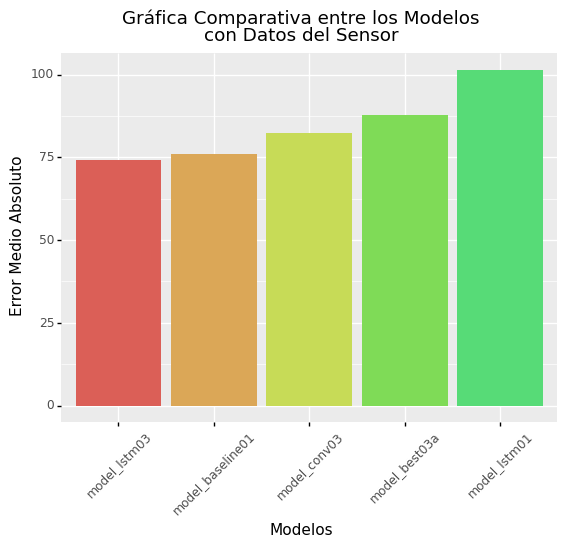

<ggplot: (8756075477117)>

In [5]:
Modelos_list = perf_data["Modelo"].tolist()
Modelos = pd.Categorical(perf_data["Modelo"], 
                         categories=Modelos_list)
perf_data["Modelo2"] = Modelos
(
  ggplot(perf_data.head(5), aes(x="Modelo2", y="val_mae", fill="Modelo2")) +
  geom_bar(stat="identity") +
  #geom_bar(aes(y="mae"), stat="identity") +
  labs(y="Error Medio Absoluto", x="Modelos", 
       title="Gráfica Comparativa entre los Modelos\ncon Datos del Sensor"
      ) +
  theme(legend_position="none", axis_text_x=element_text(rotation=45))
)

# Referencias

* Keras contributors et al. [Keras / Code examples / Timeseries / Timeseries forecasting for weather prediction](https://keras.io/examples/timeseries/timeseries_weather_forecasting/). 2021.

* Tensorflow Contributors. [Tensorflow: Tutorial on Time series forecastingTime series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_serieshttps://www.tensorflow.org/tutorials/structured_data/time_series). 2021.

* Román-Rangel, Francisco. Notas y Código del Curso de Aprendizaje Profundo. 2021.

* González-Pérez, Felipe. [Notas de aprendizaje de máquina (2020)](https://lucid-torvalds-517e78.netlify.app/)
